# Base CNN Model Experiments

In [169]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from collections import defaultdict
import time

## Loading the MNIST Dataset

In [207]:
def load_mnist_data(train=True):
    return datasets.MNIST(root='./data', train=train, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]))

In [208]:
mnist_train = load_mnist_data()

In [209]:
mnist_test = load_mnist_data(train=False)

In [173]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=False)

In [174]:
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Visualizing the Dataset

In [175]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

label_map = defaultdict(list)
count = 0
for i in range(100):
    label = example_targets[i].item()
    if len(label_map[label]) < 5:
        label_map[label].append(example_data[i][0])
        count += 1
    if count == 50:
        break

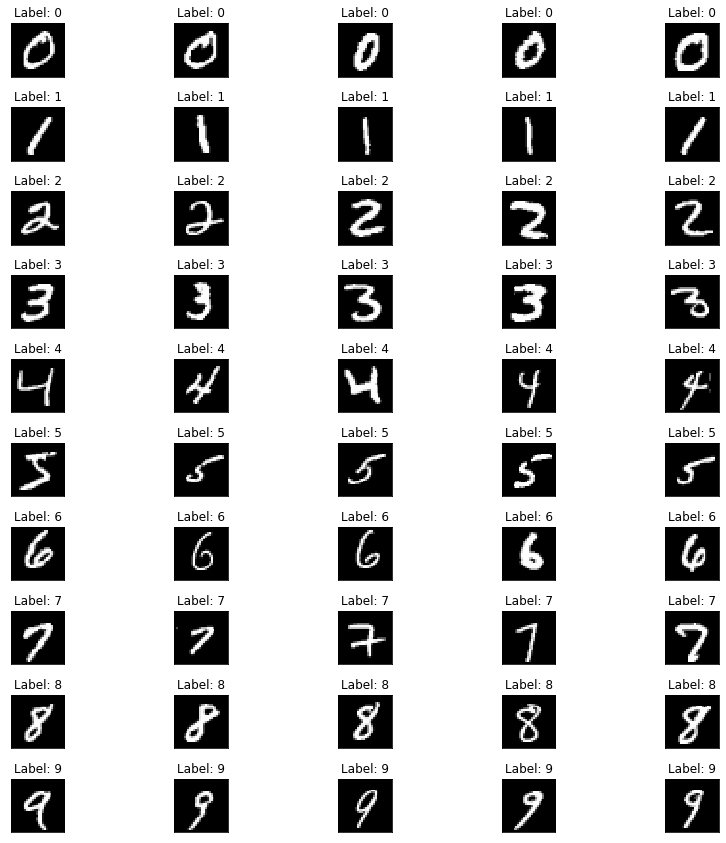

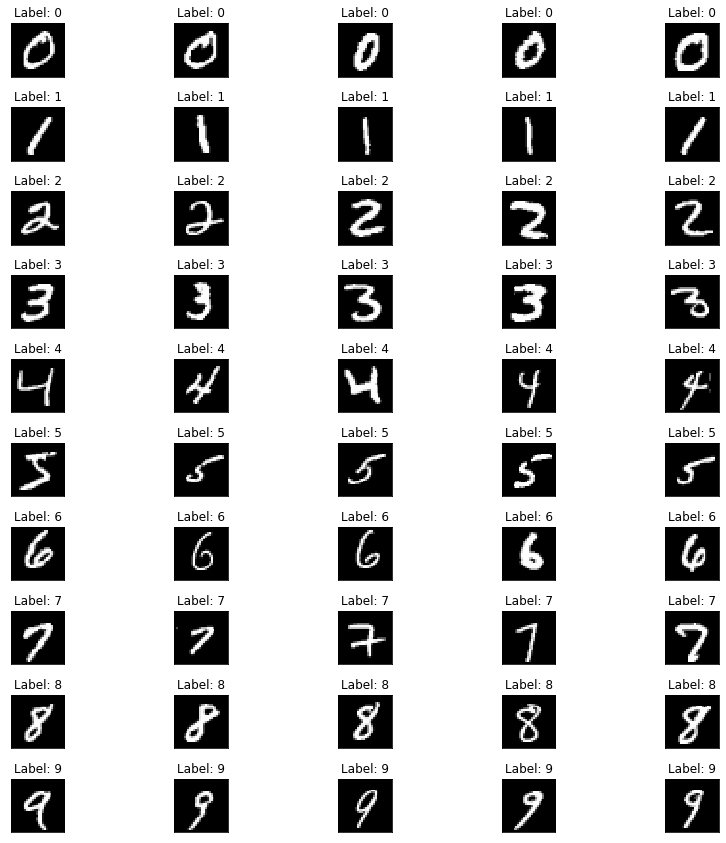

In [176]:
fig = plt.figure(figsize=(12, 12))
count = 0
for i in sorted(label_map.keys()):
    for j in range(5):
        plt.subplot(10, 5, count+1)
        plt.tight_layout()
        plt.imshow(label_map[i][j], cmap='gray', interpolation='none')
        plt.title("Label: {}".format(i))
        plt.xticks([])
        plt.yticks([])
        count += 1
fig

## Initializing the DataLoaders

In [228]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)

In [229]:
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

## Initializing the Models and Default Hyperparameters

There are two parts to this:

1. The Base CNN model: this is the 3 layer CNN that we train on the default hyperparameter settings.
2. The variations: For this part, we choose two different sets of hyperparameters: in my case, I chose two different architectures (VGG16 and SqueezeNet) and two different learning rates.

In [230]:
# Hyperparameters
batch_size = 64
n_epochs = 10
lr = 0.001

### 1. The Base CNN Model (3 Layers)

This is the base model on which we train a subset of the data. The model has 3 layers: a CONV layer, POOL layer, and a Fully Connected layer.

In [241]:
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 14 * 14, 10)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [242]:
model = BaseCNN()

In [243]:
print(model)

BaseCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12544, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)


In [244]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
writer = SummaryWriter('./logs/basecnn-default')

In [245]:
# Training
start = time.time()
running_loss = 0.0
for epoch in range(n_epochs):
    correct = 0
    for idx, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X)
        
        loss = criterion(y_pred, y)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        for i, p in enumerate(y_pred):
            if y[i] == torch.max(p.data, 0)[1]:
                correct += 1
        if (idx + 1) % 50 == 0:
            print(f'Epoch: {epoch + 1}/{n_epochs}, Batch {idx+1}/{int(len(mnist_train) / batch_size)}, Train Loss: {running_loss / 50}')
            writer.add_scalar('training loss', running_loss / 50, epoch * len(mnist_train) + idx)
            running_loss = 0.0
    accuracy = correct / len(mnist_train)
    print(f'Epoch: {epoch + 1}/1, Train Acc: {accuracy}')

end = time.time()
print(f'Elapsed time: {end - start}s')

Epoch: 1/10, Batch 50/937, Train Loss: 2.238138699531555
Epoch: 1/10, Batch 100/937, Train Loss: 2.1134078884124756
Epoch: 1/10, Batch 150/937, Train Loss: 1.9771215867996217
Epoch: 1/10, Batch 200/937, Train Loss: 1.8238034296035766
Epoch: 1/10, Batch 250/937, Train Loss: 1.6548388481140137
Epoch: 1/10, Batch 300/937, Train Loss: 1.467393445968628
Epoch: 1/10, Batch 350/937, Train Loss: 1.295283522605896
Epoch: 1/10, Batch 400/937, Train Loss: 1.1131821775436401
Epoch: 1/10, Batch 450/937, Train Loss: 0.9681955409049988
Epoch: 1/10, Batch 500/937, Train Loss: 0.8641969251632691
Epoch: 1/10, Batch 550/937, Train Loss: 0.7557944178581237
Epoch: 1/10, Batch 600/937, Train Loss: 0.7077377080917359
Epoch: 1/10, Batch 650/937, Train Loss: 0.6484136176109314
Epoch: 1/10, Batch 700/937, Train Loss: 0.5927161383628845
Epoch: 1/10, Batch 750/937, Train Loss: 0.5812256240844726
Epoch: 1/10, Batch 800/937, Train Loss: 0.535203994512558
Epoch: 1/10, Batch 850/937, Train Loss: 0.5422217720746993
Ep

Epoch: 8/10, Batch 450/937, Train Loss: 0.23804217927157878
Epoch: 8/10, Batch 500/937, Train Loss: 0.25320480272173884
Epoch: 8/10, Batch 550/937, Train Loss: 0.27224885269999505
Epoch: 8/10, Batch 600/937, Train Loss: 0.2619018413126469
Epoch: 8/10, Batch 650/937, Train Loss: 0.2563506174087524
Epoch: 8/10, Batch 700/937, Train Loss: 0.2376652467250824
Epoch: 8/10, Batch 750/937, Train Loss: 0.242841624841094
Epoch: 8/10, Batch 800/937, Train Loss: 0.24985136911273004
Epoch: 8/10, Batch 850/937, Train Loss: 0.22779536187648775
Epoch: 8/10, Batch 900/937, Train Loss: 0.25568914830684664
Epoch: 8/1, Train Acc: 0.9258833333333333
Epoch: 9/10, Batch 50/937, Train Loss: 0.4375941227376461
Epoch: 9/10, Batch 100/937, Train Loss: 0.25618392273783686
Epoch: 9/10, Batch 150/937, Train Loss: 0.23201241120696067
Epoch: 9/10, Batch 200/937, Train Loss: 0.23744263902306556
Epoch: 9/10, Batch 250/937, Train Loss: 0.2389062164723873
Epoch: 9/10, Batch 300/937, Train Loss: 0.2529619248211384
Epoch: 

In [246]:
torch.save(model.state_dict(), './models/basecnn-default.pt')

In [247]:
print(len(mnist_test))

10000


In [248]:
# Test
start = time.time()
correct = 0
for idx, (X, y) in enumerate(test_loader):
    y_pred = model(X)    
    for i, p in enumerate(y_pred):
        if y[i] == torch.max(p.data, 0)[1]:
            correct += 1

accuracy = correct / len(mnist_test)
print(f'Test Accuracy: {accuracy}')
end = time.time()
print(f'Elapsed time: {end - start}s')

Test Accuracy: 0.9355
Elapsed time: 6.482763051986694s


### Confusion Matrix

In [249]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [250]:
y_true_full = []
y_pred_full = []
correct = 0
for idx, (X, y) in enumerate(test_loader):
    y_pred = model(X)    
    for i, p in enumerate(y_pred):
        if y[i] == torch.max(p.data, 0)[1]:
            correct += 1
        y_true_full.append(y[i])
        y_pred_full.append(torch.max(p.data, 0)[1])

In [251]:
cf = confusion_matrix(y_true_full, y_pred_full, labels=[i for i in range(10)])

<AxesSubplot:title={'center':'Confusion matrix for all 10 digit classes (Base CNN Model)'}>

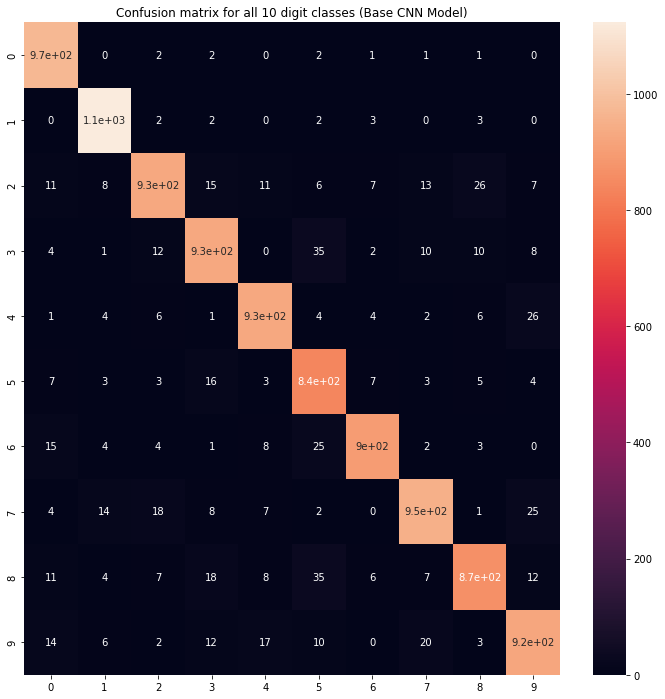

In [252]:
plt.figure(figsize = (12, 12))
plt.title('Confusion matrix for all 10 digit classes (Base CNN Model)')
sns.heatmap(cf, annot=True)

### Experiment 2: Outlier Test on the Base CNN Model

### Experiment 3: The Base CNN Model with an LR of 0.1 and # Epochs = 5

In [257]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)

In [254]:
# Hyperparameters
batch_size = 64
n_epochs = 5
lr = 0.1

In [262]:
model = BaseCNN()

In [263]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
writer = SummaryWriter('./logs/basecnn-0.1-5')

In [265]:
# Training
start = time.time()
running_loss = 0.0
for epoch in range(n_epochs):
    correct = 0
    for idx, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        for i, p in enumerate(y_pred):
            if y[i] == torch.max(p.data, 0)[1]:
                correct += 1
        if (idx + 1) % 50 == 0:
            print(f'Epoch: {epoch + 1}/{n_epochs}, Batch {idx+1}/{int(len(mnist_train) / batch_size)}, Train Loss: {running_loss / 50}')
            writer.add_scalar('training loss', running_loss / 50, epoch * len(mnist_train) + idx)
            running_loss = 0.0
    accuracy = correct / len(mnist_train)
    print(f'Epoch: {epoch + 1}/1, Train Acc: {accuracy}')

end = time.time()
print(f'Elapsed time: {end - start}s')

Epoch: 1/5, Batch 50/937, Train Loss: 0.4726261430978775
Epoch: 1/5, Batch 100/937, Train Loss: 0.2795935332775116
Epoch: 1/5, Batch 150/937, Train Loss: 0.19533200234174727
Epoch: 1/5, Batch 200/937, Train Loss: 0.16234272696077823
Epoch: 1/5, Batch 250/937, Train Loss: 0.13048515878617764
Epoch: 1/5, Batch 300/937, Train Loss: 0.13671571098268032
Epoch: 1/5, Batch 350/937, Train Loss: 0.11311208486557006
Epoch: 1/5, Batch 400/937, Train Loss: 0.11339104946702719
Epoch: 1/5, Batch 450/937, Train Loss: 0.11906391691416501
Epoch: 1/5, Batch 500/937, Train Loss: 0.09048844199627638
Epoch: 1/5, Batch 550/937, Train Loss: 0.09165226951241494
Epoch: 1/5, Batch 600/937, Train Loss: 0.0978086805716157
Epoch: 1/5, Batch 650/937, Train Loss: 0.08526299199089409
Epoch: 1/5, Batch 700/937, Train Loss: 0.07575336745008826
Epoch: 1/5, Batch 750/937, Train Loss: 0.08871186200529337
Epoch: 1/5, Batch 800/937, Train Loss: 0.07876893429085613
Epoch: 1/5, Batch 850/937, Train Loss: 0.0795675902441144
Ep

In [266]:
torch.save(model.state_dict(), './models/basecnn-0.1-5.pt')

In [267]:
# Test
start = time.time()
correct = 0
for idx, (X, y) in enumerate(test_loader):
    y_pred = model(X)    
    for i, p in enumerate(y_pred):
        if y[i] == torch.max(p.data, 0)[1]:
            correct += 1

accuracy = correct / len(mnist_test)
print(f'Test Accuracy: {accuracy}')
end = time.time()
print(f'Elapsed time: {end - start}s')

Test Accuracy: 0.9838
Elapsed time: 6.675978183746338s


In [268]:
y_true_full = []
y_pred_full = []
correct = 0
for idx, (X, y) in enumerate(test_loader):
    y_pred = model(X)    
    for i, p in enumerate(y_pred):
        if y[i] == torch.max(p.data, 0)[1]:
            correct += 1
        y_true_full.append(y[i])
        y_pred_full.append(torch.max(p.data, 0)[1])

<AxesSubplot:title={'center':'Confusion matrix for all 10 digit classes (Base CNN Model)'}>

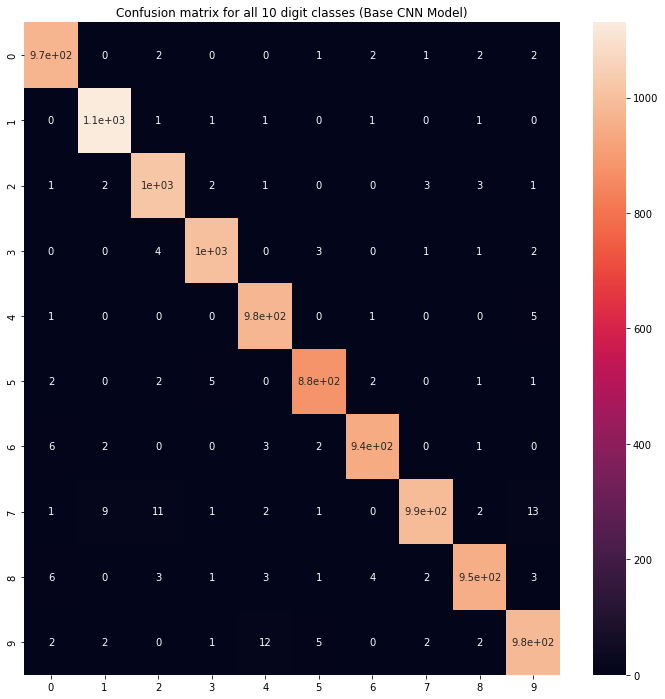

In [269]:
cf = confusion_matrix(y_true_full, y_pred_full, labels=[i for i in range(10)])
plt.figure(figsize = (12, 12))
plt.title('Confusion matrix for all 10 digit classes (Base CNN Model)')
sns.heatmap(cf, annot=True)

In [272]:
def train_model(model, name, n_epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    writer = SummaryWriter(f'./logs/{name}')
    
    # Training
    start = time.time()
    running_loss = 0.0
    for epoch in range(n_epochs):
        correct = 0
        for idx, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            for i, p in enumerate(y_pred):
                if y[i] == torch.max(p.data, 0)[1]:
                    correct += 1
            if (idx + 1) % 50 == 0:
                print(f'Epoch: {epoch + 1}/{n_epochs}, Batch {idx+1}/{int(len(mnist_train) / batch_size)}, Train Loss: {running_loss / 50}')
                writer.add_scalar('training loss', running_loss / 50, epoch * len(mnist_train) + idx)
                running_loss = 0.0
        accuracy = correct / len(mnist_train)
        print(f'Epoch: {epoch + 1}/1, Train Acc: {accuracy}')

    end = time.time()
    print(f'Elapsed time: {end - start}s')
    
    torch.save(model.state_dict(), f'./models/{name}.pt')

In [282]:
def test_model(model):
    test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)
    # Test
    start = time.time()
    correct = 0
    for idx, (X, y) in enumerate(test_loader):
        y_pred = model(X)    
        for i, p in enumerate(y_pred):
            if y[i] == torch.max(p.data, 0)[1]:
                correct += 1

    accuracy = correct / len(mnist_test)
    print(f'Test Accuracy: {accuracy}')
    end = time.time()
    print(f'Elapsed time: {end - start}s')

In [285]:
def plot_cf(model):
    y_true_full = []
    y_pred_full = []
    correct = 0
    for idx, (X, y) in enumerate(test_loader):
        y_pred = model(X)    
        for i, p in enumerate(y_pred):
            if y[i] == torch.max(p.data, 0)[1]:
                correct += 1
            y_true_full.append(y[i])
            y_pred_full.append(torch.max(p.data, 0)[1])
    cf = confusion_matrix(y_true_full, y_pred_full, labels=[i for i in range(10)])
    plt.figure(figsize = (12, 12))
    plt.title('Confusion matrix for all 10 digit classes (Base CNN Model)')
    sns.heatmap(cf, annot=True)

### Experiment 4: The Base CNN Model with an LR of 0.1 and # Epochs = 8

In [276]:
model = BaseCNN()

In [277]:
train_model(model, 'basecnn-0.1-8', 8, 0.1)

Epoch: 1/8, Batch 50/937, Train Loss: 0.8263021019101143
Epoch: 1/8, Batch 100/937, Train Loss: 0.31144639402627944
Epoch: 1/8, Batch 150/937, Train Loss: 0.2141619887948036
Epoch: 1/8, Batch 200/937, Train Loss: 0.15727238193154336
Epoch: 1/8, Batch 250/937, Train Loss: 0.14721983700990676
Epoch: 1/8, Batch 300/937, Train Loss: 0.10493755247443914
Epoch: 1/8, Batch 350/937, Train Loss: 0.12706368379294872
Epoch: 1/8, Batch 400/937, Train Loss: 0.10555589646100998
Epoch: 1/8, Batch 450/937, Train Loss: 0.09342397089116275
Epoch: 1/8, Batch 500/937, Train Loss: 0.0821349262446165
Epoch: 1/8, Batch 550/937, Train Loss: 0.0853099400177598
Epoch: 1/8, Batch 600/937, Train Loss: 0.08174338292330503
Epoch: 1/8, Batch 650/937, Train Loss: 0.07372682692483068
Epoch: 1/8, Batch 700/937, Train Loss: 0.0791703821811825
Epoch: 1/8, Batch 750/937, Train Loss: 0.08017427137121558
Epoch: 1/8, Batch 800/937, Train Loss: 0.07662742231041193
Epoch: 1/8, Batch 850/937, Train Loss: 0.08729779759421945
Epo

Epoch: 8/8, Batch 450/937, Train Loss: 0.01874752095376607
Epoch: 8/8, Batch 500/937, Train Loss: 0.017901959090377204
Epoch: 8/8, Batch 550/937, Train Loss: 0.01607467436231673
Epoch: 8/8, Batch 600/937, Train Loss: 0.021262457539560273
Epoch: 8/8, Batch 650/937, Train Loss: 0.0249899469781667
Epoch: 8/8, Batch 700/937, Train Loss: 0.023178341786842794
Epoch: 8/8, Batch 750/937, Train Loss: 0.01927297276328318
Epoch: 8/8, Batch 800/937, Train Loss: 0.02437822917010635
Epoch: 8/8, Batch 850/937, Train Loss: 0.021689219502732157
Epoch: 8/8, Batch 900/937, Train Loss: 0.022052225776715204
Epoch: 8/1, Train Acc: 0.9937666666666667
Elapsed time: 850.3954989910126s


In [300]:
model = BaseCNN()

In [301]:
model.load_state_dict(torch.load('./models/basecnn-0.1-8.pt'))

<All keys matched successfully>

In [302]:
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)
# Test
start = time.time()
correct = 0
for idx, (X, y) in enumerate(test_loader):
    y_pred = model(X)    
    for i, p in enumerate(y_pred):
        if y[i] == torch.max(p.data, 0)[1]:
            correct += 1

accuracy = correct / len(mnist_test)
print(f'Test Accuracy: {accuracy}')
end = time.time()
print(f'Elapsed time: {end - start}s')

Test Accuracy: 0.986
Elapsed time: 7.0186333656311035s


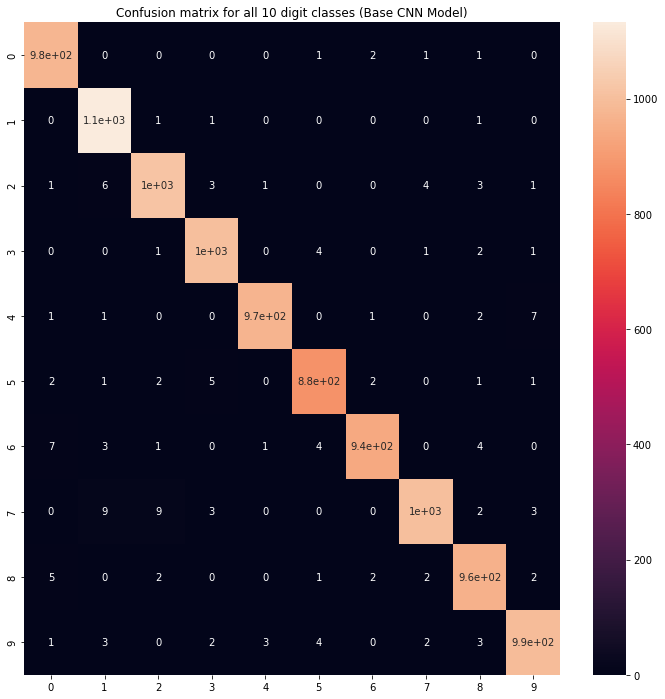

In [303]:
plot_cf(model)

### Experiment 5: The Base CNN Model with an LR of 0.01 and # Epochs = 5

In [287]:
model = BaseCNN()

In [288]:
train_model(model, 'basecnn-0.01-5', 5, 0.01)

Epoch: 1/5, Batch 50/937, Train Loss: 1.6717056167125701
Epoch: 1/5, Batch 100/937, Train Loss: 0.6821021258831024
Epoch: 1/5, Batch 150/937, Train Loss: 0.4854862642288208
Epoch: 1/5, Batch 200/937, Train Loss: 0.38817349195480344
Epoch: 1/5, Batch 250/937, Train Loss: 0.39476951777935027
Epoch: 1/5, Batch 300/937, Train Loss: 0.33648482263088225
Epoch: 1/5, Batch 350/937, Train Loss: 0.3436106938123703
Epoch: 1/5, Batch 400/937, Train Loss: 0.36178542420268056
Epoch: 1/5, Batch 450/937, Train Loss: 0.29152919471263883
Epoch: 1/5, Batch 500/937, Train Loss: 0.3073250296711922
Epoch: 1/5, Batch 550/937, Train Loss: 0.28277502715587616
Epoch: 1/5, Batch 600/937, Train Loss: 0.301955032646656
Epoch: 1/5, Batch 650/937, Train Loss: 0.2585171571373939
Epoch: 1/5, Batch 700/937, Train Loss: 0.27479909896850585
Epoch: 1/5, Batch 750/937, Train Loss: 0.2858708482980728
Epoch: 1/5, Batch 800/937, Train Loss: 0.2703097724914551
Epoch: 1/5, Batch 850/937, Train Loss: 0.2657787895202637
Epoch: 1/

In [296]:
model = BaseCNN()

In [297]:
model.load_state_dict(torch.load('./models/basecnn-0.01-5.pt'))

<All keys matched successfully>

In [294]:
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)
# Test
start = time.time()
correct = 0
for idx, (X, y) in enumerate(test_loader):
    y_pred = model(X)    
    for i, p in enumerate(y_pred):
        if y[i] == torch.max(p.data, 0)[1]:
            correct += 1

accuracy = correct / len(mnist_test)
print(f'Test Accuracy: {accuracy}')
end = time.time()
print(f'Elapsed time: {end - start}s')

Test Accuracy: 0.9798
Elapsed time: 6.512987852096558s


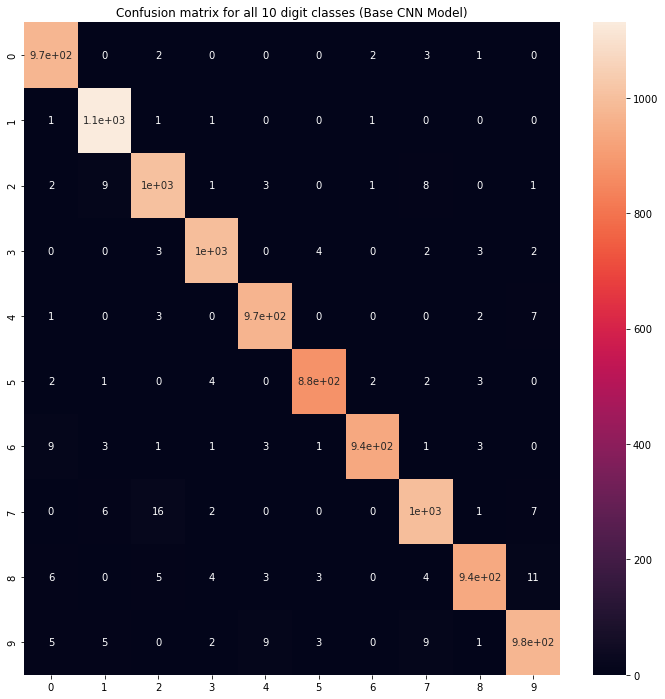

In [298]:
plot_cf(model)

### Experiment 6: The Base CNN Model with an LR of 0.01 and # Epochs = 8

In [304]:
model = BaseCNN()

In [ ]:
train_model(model, 'basecnn-0.01-8', 8, 0.01)

Epoch: 1/8, Batch 50/937, Train Loss: 1.5076163041591644
Epoch: 1/8, Batch 100/937, Train Loss: 0.622716053724289
Epoch: 1/8, Batch 150/937, Train Loss: 0.468059179186821
Epoch: 1/8, Batch 200/937, Train Loss: 0.4239205852150917
Epoch: 1/8, Batch 250/937, Train Loss: 0.38509546607732775
Epoch: 1/8, Batch 300/937, Train Loss: 0.3375234803557396
Epoch: 1/8, Batch 350/937, Train Loss: 0.3499438866972923
Epoch: 1/8, Batch 400/937, Train Loss: 0.3245355007052422
Epoch: 1/8, Batch 450/937, Train Loss: 0.35104254245758054
Epoch: 1/8, Batch 500/937, Train Loss: 0.3289066883921623
Epoch: 1/8, Batch 550/937, Train Loss: 0.3158382201194763
Epoch: 1/8, Batch 600/937, Train Loss: 0.32403082042932513
Epoch: 1/8, Batch 650/937, Train Loss: 0.31438664108514786
Epoch: 1/8, Batch 700/937, Train Loss: 0.30740679666399956
Epoch: 1/8, Batch 750/937, Train Loss: 0.2902198266983032
Epoch: 1/8, Batch 800/937, Train Loss: 0.2722489994764328
Epoch: 1/8, Batch 850/937, Train Loss: 0.2703132738173008
Epoch: 1/8, 

In [ ]:
model = BaseCNN()

In [ ]:
model.load_state_dict(torch.load('./models/basecnn-0.01-8.pt'))

In [ ]:
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)
# Test
start = time.time()
correct = 0
for idx, (X, y) in enumerate(test_loader):
    y_pred = model(X)    
    for i, p in enumerate(y_pred):
        if y[i] == torch.max(p.data, 0)[1]:
            correct += 1

accuracy = correct / len(mnist_test)
print(f'Test Accuracy: {accuracy}')
end = time.time()
print(f'Elapsed time: {end - start}s')

In [ ]:
plot_cf(model)